<a href="https://colab.research.google.com/github/Nexux69/Smart-Waste-Classifier-/blob/main/waste_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

from zipfile import ZipFile
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from zipfile import ZipFile

data_path = '/content/drive/MyDrive/Colab Notebooks/Smart waste/waste.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')

The data set has been extracted.


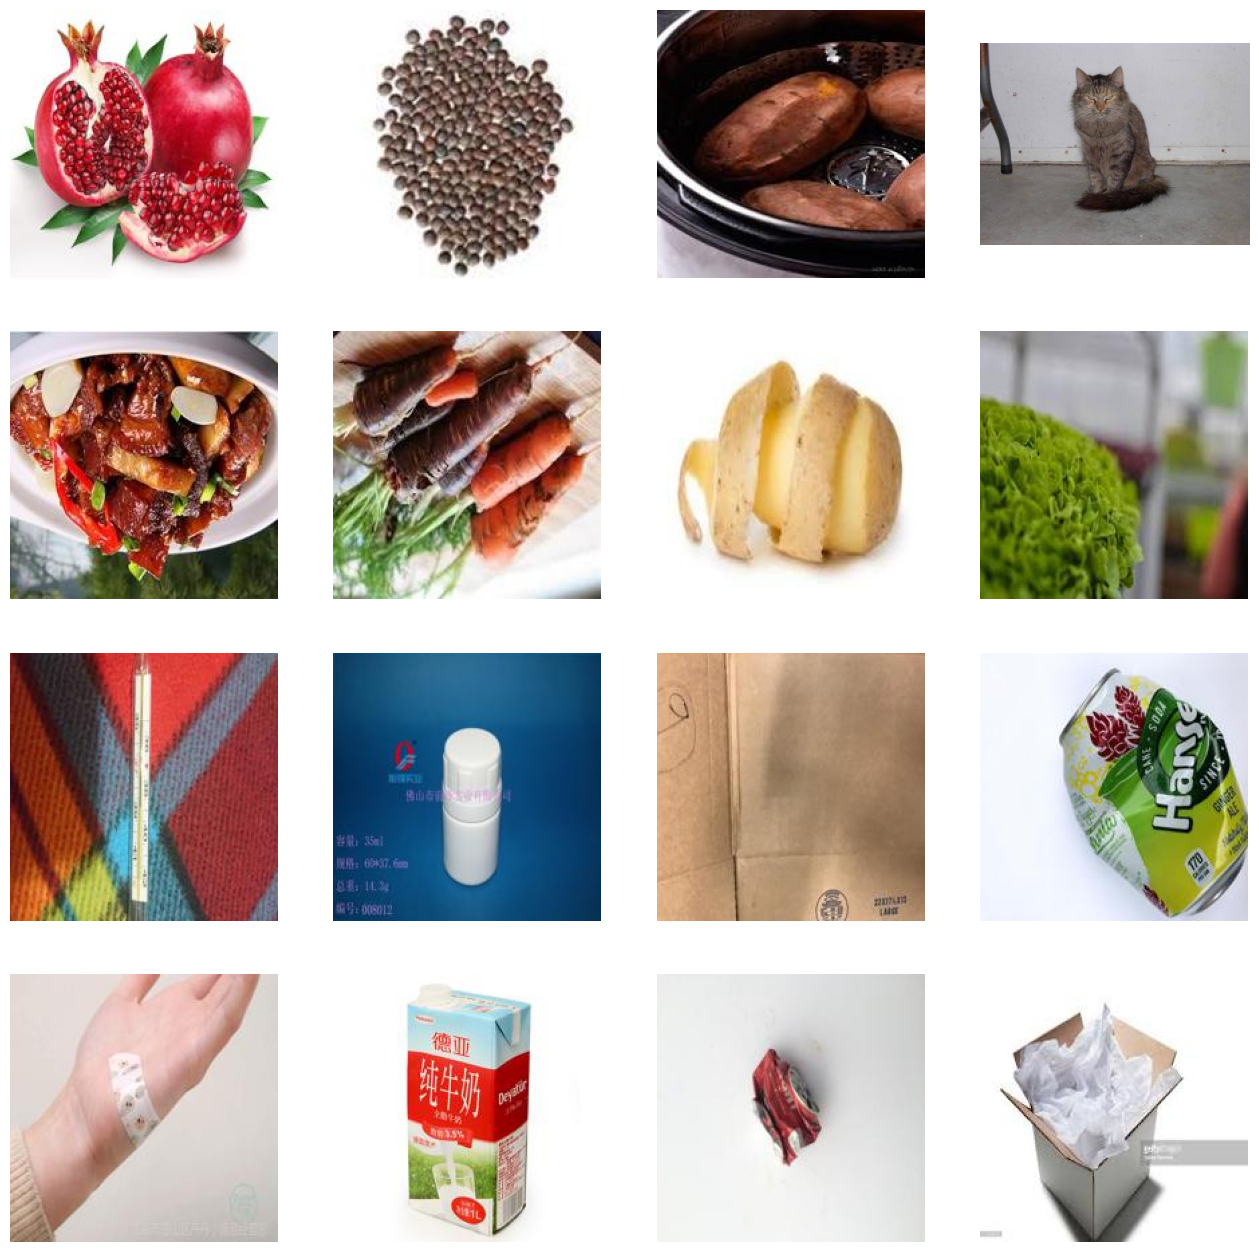

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

bio_dir = '/content/dataset/Biodegradable'
nonbio_dir = '/content/dataset/NonBiodegradable'
bio_names = os.listdir(bio_dir)
nonbio_names = os.listdir(nonbio_dir)

pic_index = 8

bio_images = [os.path.join(bio_dir, fname) for fname in bio_names[:pic_index]]
nonbio_images = [os.path.join(nonbio_dir, fname) for fname in nonbio_names[:pic_index]]

for i, img_path in enumerate(bio_images + nonbio_images):
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    img = plt.imread(img_path)
    plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/dataset'

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

train_dataset = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_dataset = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 12800 images belonging to 2 classes.
Found 3199 images belonging to 2 classes.


In [ ]:

# ✅ Get class names
CLASSES = list(train_dataset.class_indices.keys())
print(f'Classes found: {CLASSES}')




# 🧠 Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# ❄️ Freeze base model layers (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# 🔧 Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)

# 🏗️ Create final model
model = Model(inputs=base_model.input, outputs=predictions)


Classes found: ['Biodegradable', 'NonBiodegradable']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,338 (9.27 MB)

 Trainable params: 172,354 (673.26 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 247s 591ms/step - accuracy: 0.8592 - loss: 0.3079 - val_accuracy: 0.9350 - val_loss: 0.1781
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 187s 467ms/step - accuracy: 0.9623 - loss: 0.1064 - val_accuracy: 0.9412 - val_loss: 0.1741
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 183s 457ms/step - accuracy: 0.9695 - loss: 0.0822 - val_accuracy: 0.9387 - val_loss: 0.1719
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 183s 459ms/step - accuracy: 0.9703 - loss: 0.0788 - val_accuracy: 0.9259 - val_loss: 0.1943
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 189s 473ms/step - accuracy: 0.9764 - loss: 0.0654 - val_accuracy: 0.9406 - val_loss: 0.1678
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 189s 474ms/step - accuracy: 0.9773 - loss: 0.0678 - val_accuracy: 0.9503 - val_loss: 0.1506
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 190s 475ms/step - accuracy: 0.9753 - loss: 0.0632 - val_accuracy: 0.9559 - val_loss: 0.1319
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 193s 484ms/step - accuracy: 0.9815 -

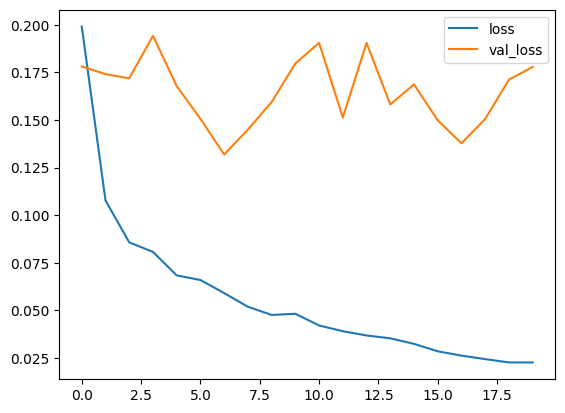

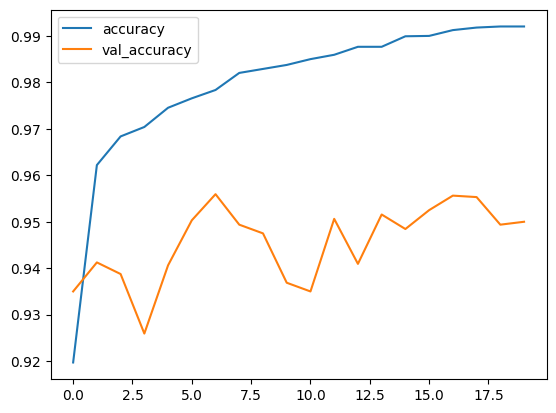

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image

# ✅ Function to predict a single image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # resize to match model input
    img_array = image.img_to_array(img) / 255.0             # normalize
    img_array = np.expand_dims(img_array, axis=0)           # add batch dimension

    predictions = model.predict(img_array)
    predicted_class = CLASSES[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    print(f"Image: {img_path}")
    print(f"Predicted: {predicted_class} ({confidence:.2f}% confidence)\n")

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.show()

# 🔹 Test with your two images
img1 = "/content/dataset/watermelon.jpg"  # change path to your test image
img2 = "/content/dataset/pen.jpgE"      # change path to your test image

predict_image(img1)
predict_image(img2)


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/watermelon.jpg'

In [ ]:
import tensorflow as tf

# 📌 Save model in TensorFlow SavedModel format (creates saved_model.pb)
tf.saved_model.save(model, "saved_model_format")

# 📦 Zip the folder
!zip -r saved_model_format.zip saved_model_format

# ⬇ Download zip (contains .pb file)
from google.colab import files
files.download("saved_model_format.zip")


  adding: saved_model_format/ (stored 0%)
  adding: saved_model_format/assets/ (stored 0%)
  adding: saved_model_format/saved_model.pb (deflated 90%)
  adding: saved_model_format/variables/ (stored 0%)
  adding: saved_model_format/variables/variables.index (deflated 77%)
  adding: saved_model_format/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model_format/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip show tensorflow


Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras
